<a href="https://colab.research.google.com/github/safaiat/CT_EXP/blob/main/c_translation/C_translation_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Iter 000 | Loss: 2.9190e+05
Iter 050 | Loss: 2.1452e+04
Iter 100 | Loss: 5.6522e+02
Iter 150 | Loss: 5.3536e+02
Iter 200 | Loss: 5.3470e+02
Iter 250 | Loss: 5.3467e+02
Iter 299 | Loss: 5.3465e+02


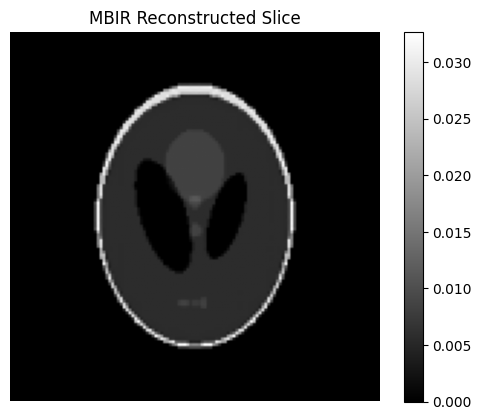

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from types import SimpleNamespace

# --- Constants ---
LEN_PIX = 256

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Param Readers ---
def read_param_file(path):
    params = {}
    with open(path, 'r') as f:
        for line in f:
            if ':' in line:
                k, v = map(str.strip, line.strip().split(':', 1))
                try:
                    params[k] = int(v)
                except ValueError:
                    try:
                        params[k] = float(v)
                    except ValueError:
                        params[k] = v
    return params

def read_angle_list(path):
    return np.loadtxt(path, dtype=np.float32)

# --- Trapezoidal Pixel-Detector Profile ---
def compute_pixel_profile(sino, img, L):
    rc = np.sin(np.pi / 4)
    prof = np.zeros((sino.NViews, L), dtype=np.float32)
    for i, ang in enumerate(sino.ViewAngles):
        ang = ang % (np.pi / 2)
        maxval = img.Deltaxy / np.cos(ang) if ang <= np.pi/4 else img.Deltaxy / np.cos(np.pi/2 - ang)
        d1 = rc * np.cos(np.pi/4 - ang)
        d2 = rc * abs(np.sin(np.pi/4 - ang))
        t1, t2, t3, t4 = 1 - d1, 1 - d2, 1 + d2, 1 + d1
        for j in range(L):
            t = 2.0 * j / L
            if t <= t1 or t > t4:
                v = 0.0
            elif t <= t2:
                v = maxval * (t - t1) / (t2 - t1)
            elif t <= t3:
                v = maxval
            else:
                v = maxval * (t4 - t) / (t4 - t3)
            prof[i, j] = v
    return prof

# --- System Matrix Computation ---
def compute_sys_matrix_column(idx, sino, img, prof, L):
    Nx, Ny = img.Nx, img.Ny
    ΔP, ΔC = img.Deltaxy, sino.DeltaChannel
    x0 = -(Nx - 1) * ΔP / 2
    y0 = -(Ny - 1) * ΔP / 2
    t0 = -(sino.NChannels - 1) * ΔC / 2 - sino.CenterOffset * ΔC

    row, col = divmod(idx, Nx)
    x = x0 + col * ΔP
    y = y0 + row * ΔP

    rows, vals = [], []
    for v in range(sino.NViews):
        ang = sino.ViewAngles[v]
        t_proj = y * np.cos(ang) - x * np.sin(ang)
        t_min, t_max = t_proj - ΔP, t_proj + ΔP
        if t_max < t0: continue
        i_min = max(0, int(np.ceil((t_min - t0) / ΔC - 0.5)))
        i_max = min(sino.NChannels - 1, int((t_max - t0) / ΔC + 0.5))
        for i in range(i_min, i_max + 1):
            det_pos = t0 + i * ΔC
            idx_prof = int((L - 1) * (det_pos - t_proj + ΔP) / (2 * ΔP) + 0.5)
            idx_prof = np.clip(idx_prof, 0, L - 1)
            w = prof[v, idx_prof]
            if w > 0:
                rows.append(v * sino.NChannels + i)
                vals.append(w)
    return rows, vals

def compute_sys_matrix(sino, img, prof, L):
    Ncols = img.Nx * img.Ny
    all_r, all_c, all_v = [], [], []
    for col in range(Ncols):
        r, v = compute_sys_matrix_column(col, sino, img, prof, L)
        all_r.extend(r)
        all_v.extend(v)
        all_c.extend([col] * len(r))
    return coo_matrix((all_v, (all_r, all_c)), shape=(sino.NViews * sino.NChannels, Ncols))

# --- Total Variation Penalty ---
def custom_tv_3d(x):
    eps = 1e-8
    tv = 0.0
    for z in range(x.shape[2]):
        sl = x[:, :, z].unsqueeze(0).unsqueeze(0)
        v = F.pad(sl[:, :, 1:, :] - sl[:, :, :-1, :], (0, 0, 0, 1))
        h = F.pad(sl[:, :, :, 1:] - sl[:, :, :, :-1], (0, 1, 0, 0))
        d1 = F.pad(sl[:, :, 1:, 1:] - sl[:, :, :-1, :-1], (0, 1, 0, 1))
        d2 = F.pad(sl[:, :, 1:, :-1] - sl[:, :, :-1, 1:], (1, 0, 0, 1))
        tv += torch.sum(torch.sqrt(v**2 + h**2 + eps) +
                        (1 / np.sqrt(2)) * torch.sqrt(d1**2 + d2**2 + eps))
    return tv

# --- Main MBIR Runner ---
def run_mbir_pipeline(
    sino_path="shepp_slice0001.2Dsinodata",
    sino_weights_path="shepp_slice0001.2Dweightdata",
    param_path="shepp.sinoparams",
    imgparam_path="shepp.imgparams",
    angle_path="shepp.ViewAngleList.txt",
    tv_weight=5.0,
    lr=1.0,
    n_iters=300
):
    sino_p = read_param_file(param_path)
    img_p = read_param_file(imgparam_path)
    angles = read_angle_list(angle_path)

    sino = SimpleNamespace(
        NViews=sino_p["NViews"],
        NChannels=sino_p["NChannels"],
        DeltaChannel=sino_p["DeltaChannel"],
        CenterOffset=sino_p["CenterOffset"],
        ViewAngles=angles
    )
    img = SimpleNamespace(
        Nx=img_p["Nx"],
        Ny=img_p["Ny"],
        Deltaxy=img_p["Deltaxy"]
    )

    # Read sinogram
    raw = np.fromfile(sino_path, dtype=np.float32)
    sino_data = raw.reshape((sino.NViews * sino.NChannels))

    # Build System Matrix
    pix_prof = compute_pixel_profile(sino, img, L=LEN_PIX)
    A = compute_sys_matrix(sino, img, pix_prof, L=LEN_PIX)
    A_i = torch.tensor(np.vstack((A.row, A.col)), dtype=torch.long, device=device)
    A_v = torch.tensor(A.data, dtype=torch.float32, device=device)
    A_t = torch.sparse_coo_tensor(A_i, A_v, A.shape, device=device)

    # Setup reconstruction
    Nz = 1
    x = torch.zeros((img.Ny, img.Nx, Nz), dtype=torch.float32, requires_grad=True, device=device)
    optimizer = optim.Adam([x], lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    y = torch.tensor(sino_data, dtype=torch.float32, device=device)

    for it in range(n_iters):
        optimizer.zero_grad()
        x_vec = x[:, :, 0].reshape(-1, 1)
        Ax = torch.sparse.mm(A_t, x_vec).squeeze()
        data_term = torch.sum((y - Ax) ** 2)
        tv_term = custom_tv_3d(x)
        loss = data_term + tv_weight * tv_term
        loss.backward()
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            x.clamp_(min=0.0)
        if it % 50 == 0 or it == n_iters - 1:
            print(f"Iter {it:03d} | Loss: {loss.item():.4e}")

    recon = x.detach().cpu().numpy()
    np.save("mbir_recon_slice.npy", recon)
    plt.imshow(recon[:, :, 0], cmap="gray")
    plt.title("MBIR Reconstructed Slice")
    plt.axis("off")
    plt.colorbar()
    plt.show()

run_mbir_pipeline()
